In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import os
import sys
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# torch.cuda.is_available()

import gym

In [2]:
seed = 1

os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

random.seed(seed)
np.random.seed(seed)

# env.seed(seed)  这个等创建了环境之后再设置

torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [3]:
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.append(path)

In [4]:
from configs import Config
from networks_pytorch import MLP_pytorch, QuantileNetwork_pytorch
from agents_pytorch import DQNAgentPytorch, QuantileDQNAgentPytorch

# Training Loop

## CartPole-v0

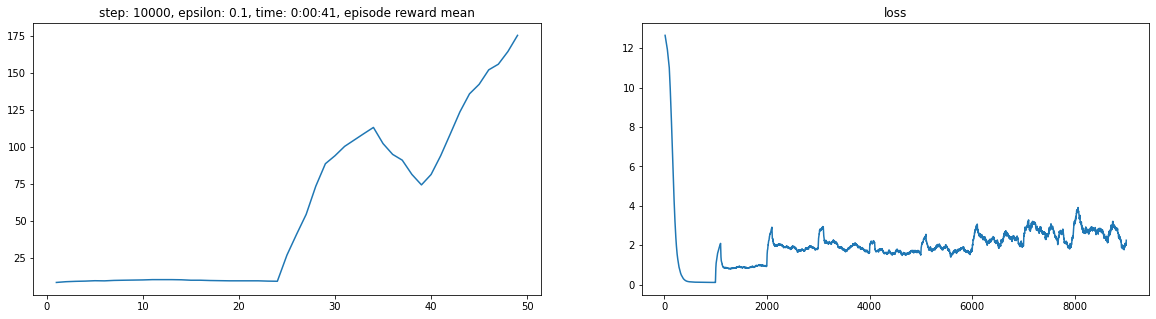

step: 11000, epsilon: 0.1, lr: 0.0001, time: 0:00:46
episode reward mean: 192.2, epsisode reward max: 200.0, episode length mean: 192.2, episode length max: 200, loss: 3.025122383236885
[(0.7825313806533813, -0.7877200245857239, 9.191401481628418, -20.489933013916016), (0.5659867525100708, -0.5462996363639832, 17.477113723754883, -28.24972152709961), (0.3965236246585846, -0.561138927936554, 2.7918877601623535, -7.883634090423584), (0.17231497168540955, -0.128636434674263, 4.472568511962891, -12.468253135681152), (0.3932299017906189, -0.4629165530204773, 2.038480758666992, -2.1594133377075195), (0.13270285725593567, -0.08886159211397171, 1.9274202585220337, -2.1068882942199707), (0.2952369749546051, -0.3742898404598236, 0.002239448484033346, -1.0393000841140747), (0.16615712642669678, -0.07926349341869354, -0.1409352719783783, -0.26373550295829773)]
step: 12000, epsilon: 0.1, lr: 0.0001, time: 0:00:51
episode reward mean: 195.8, epsisode reward max: 200.0, episode length mean: 195.8, ep

In [5]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()
# config.epsilon_start = 1.
# config.epsilon_end = 0.01

start = timer()

dqn_agent = QuantileDQNAgentPytorch(env_name=name, network=QuantileNetwork_pytorch, config=config)


obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.param_groups[0]['lr'], timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        print('=========================================')
        print([(param.data.max().item(), param.data.min().item(), param.grad.data.max().item(), param.grad.data.min().item()) for param in dqn_agent.model.parameters()])
        print('=========================================')
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-20:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
        if mean_returns > 195:
            break 
        
# dqn_agent.render(env_eval)

In [6]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

197.7


In [7]:
torch.save(dqn_agent.model.state_dict(), 'quantiledqn_cartpole.pt')

In [8]:
dqn_agent.render(env_eval)

## LunarLander-v2

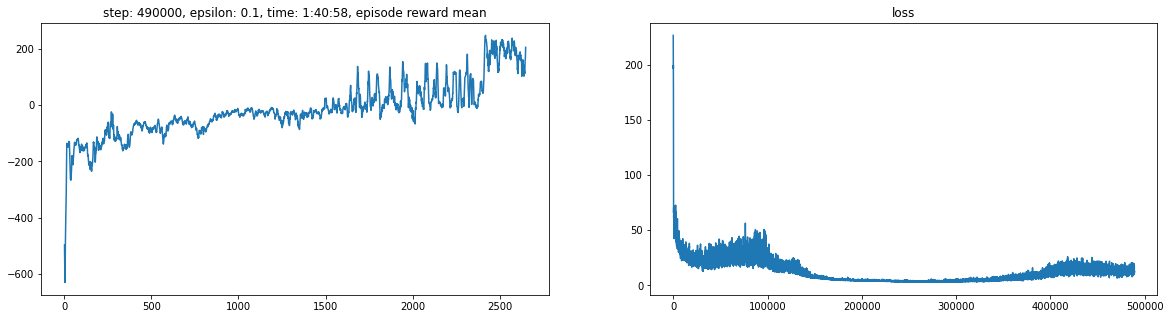

step: 491000, epsilon: 0.1, lr: 0.0001, time: 1:41:05
episode reward mean: 230.61650456480203, epsisode reward max: 298.7321789257378, episode length mean: 545.4, episode length max: 856, loss: 17.375561702251435
[(1.5038775205612183, -1.0967904329299927, 30.87546157836914, -59.27685546875), (0.5637862086296082, -0.36571890115737915, 112.05787658691406, -148.57225036621094), (1.7461439371109009, -1.5584324598312378, 13.368681907653809, -8.786650657653809), (0.42246443033218384, -0.3339315950870514, 20.844419479370117, -13.135660171508789), (1.2170014381408691, -1.557578444480896, 3.38446307182312, -5.558193206787109), (0.31549859046936035, -0.10377982258796692, 0.8433548808097839, -1.481410264968872), (1.6099534034729004, -0.6346333026885986, 0.1505178064107895, -0.7751326560974121), (0.3573644757270813, -0.16958163678646088, 0.011344650760293007, -0.04469122365117073)]
step: 492000, epsilon: 0.1, lr: 0.0001, time: 1:41:11
episode reward mean: 181.0773407626604, epsisode reward max: 26

In [5]:
name = 'LunarLander-v2'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()
# config.epsilon_start = 1.
# config.epsilon_end = 0.01

start = timer()

dqn_agent = QuantileDQNAgentPytorch(env_name=name, network=QuantileNetwork_pytorch, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.param_groups[0]['lr'], timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        print('=========================================')
        print([(param.data.max().item(), param.data.min().item(), param.grad.data.max().item(), param.grad.data.min().item()) for param in dqn_agent.model.parameters()])
        print('=========================================')
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-20:]).mean() > 200:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
        if mean_returns > 195:
            break 
        
# dqn_agent.render(env_eval)

In [6]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

218.8365184400982


In [7]:
torch.save(dqn_agent.model.state_dict(), 'quantiledqn_lunarlander.pt')

In [8]:
dqn_agent.render(env_eval)